In [72]:
cd("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior")
import Pkg; 
Pkg.activate(".")

using Plots
using Term
import Term: install_term_logger
import Term.progress: track as pbar
import MyterialColors: grey_dark, grey, pink, pink_dark
using Colors, CSV
import DataFrames: DataFrame

using jcontrol
using jcontrol.visuals
install_term_logger();
import jcontrol: ξ

  Activating project at `~/Documents/Github/LocomotionControl/analysis/behavior`


Animation of tracking data overlayed over the arena. Can also show results from models.

In [73]:
# load trials
trials = load_cached_trials(; keep_n = nothing);
@info "Loaded $(length(trials)) trials"
ntrials = length(trials)

X = getfield.(trials, :x)
Y = getfield.(trials, :y)
Θ = getfield.(trials, :θ)

N = max(map(t->length(t.x), trials)...)
nothing

@Info (Main):  Loaded 310 trials
  ╰────────────────────────────────────────────────
                      Mon, 25 Apr 2022 09:24:43


In [74]:
# Load MTM solution
globalsolution = DataFrame(CSV.File(joinpath(PATHS["horizons_sims_cache"], "global_solution.csv")))
globalsolution = Solution(globalsolution);

make animation

In [75]:
# parameters
COLORBY = nothing
SIMULATION = true
l = 1.5  # length of "mouse" line


if COLORBY == :s
    colors = ξ(range(colorant"#e374bc", colorant"#6b92e8", length=260))
elseif COLORBY == :trial
    colors = range(colorant"#e374bc", colorant"#6b92e8", length=min(N_trials, ntrials))
elseif COLORBY == :speed
    colors = ξ(colormap("Reds", 100))
else
    colors = nothing
end


@Info (Plots.#buildanimation#237):  Saved animation to 
  │
  │ (String)  ▶  fn = /Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Videos/tracking_animation_colorby_nothing_mtmsolution_true.gif
  ╰────────────────────────────────────────────────
                      Mon, 25 Apr 2022 09:43:20


@Info (Plots.#buildanimation#237):  Saved animation to 
  │


  │ (String)  ▶  fn = /Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Videos/tracking_animation_colorby_nothing_mtmsolution_true.mp4
  ╰────────────────────────────────────────────────
                      Mon, 25 Apr 2022 09:43:21


Plots.AnimatedGif("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Videos/tracking_animation_colorby_nothing_mtmsolution_true.gif")
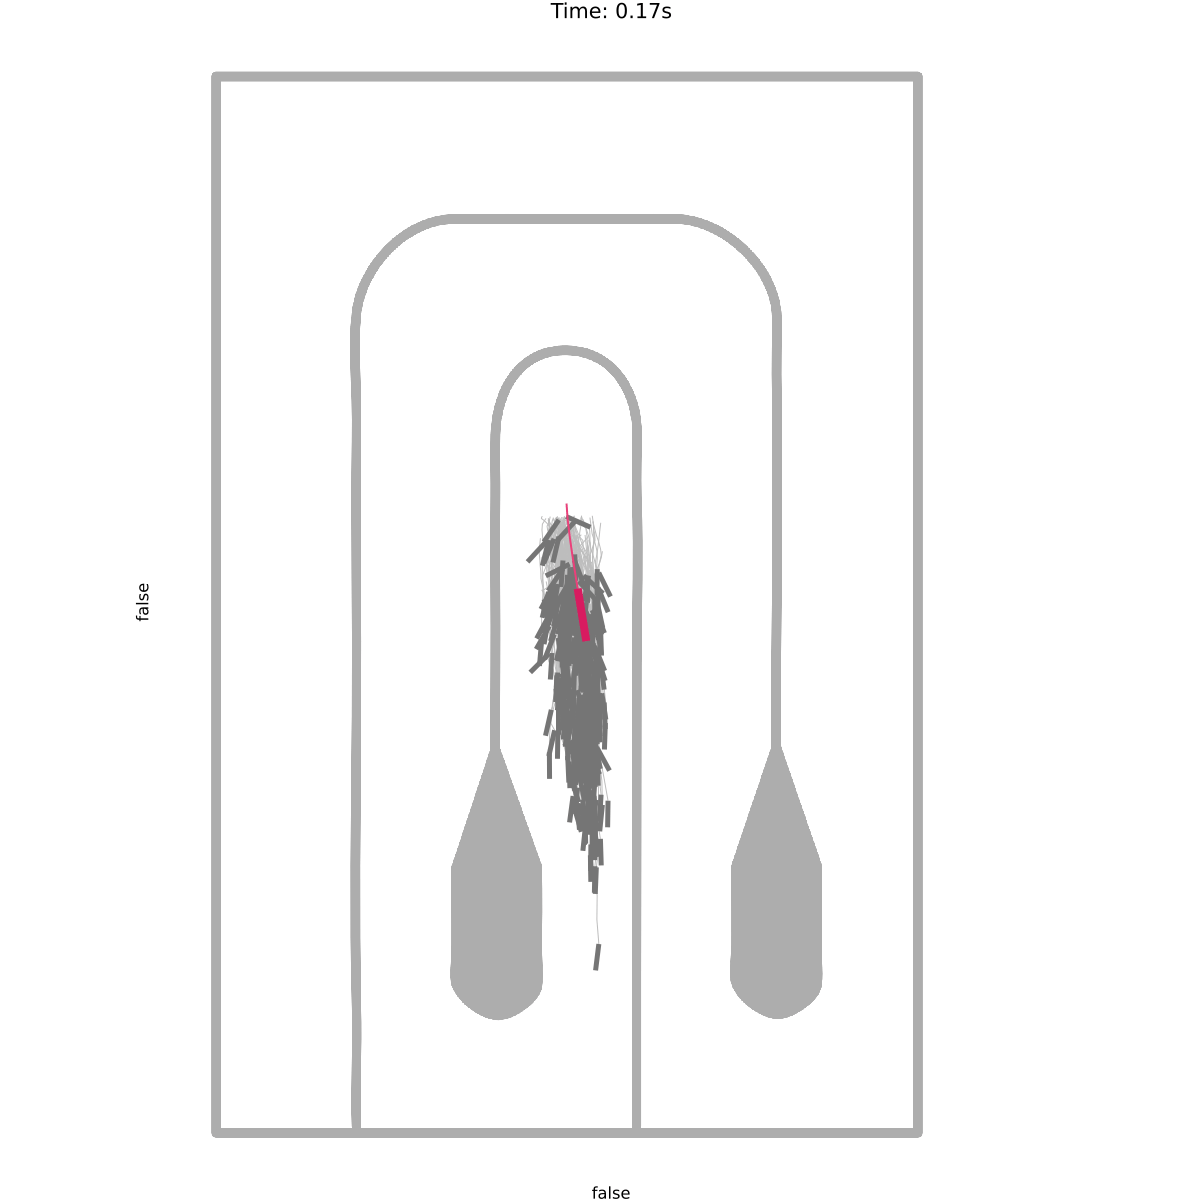

In [79]:
# animatin maker
anim = @animate for i in 1:N
    time = i * 1/60
    time > 6.0 && continue

    if i % 10 != 0
        continue
    end

    plt = draw(:arena)
    plot!(;xlim=[0, 45], ylim=[0, 60], axis=nothing, xlabel=false, ylabel=false, showaxis = false, title="Time: $(round(i/60; digits=2))s")

    # first plot tracking traces
    for t in 1:ntrials
        if i > length(X[t]) 
            # plot whole trace, the trial ended
            plot!(X[t], Y[t], color=grey, lw=1, label=nothing)
        else
            # plot up to frame + mouse orientation
            plot!(X[t][1:i], Y[t][1:i], color=grey, lw=1, label=nothing)
        end
    end

    # then plot mice
    for t in 1:ntrials
        idx = i > length(X[t]) ? length(X[t]) : i
        # draw a line for the mouse
        x, y, _θ = X[t][idx], Y[t][idx], Θ[t][idx]
        

        if COLORBY == :s
            color = colors[max(trials[t].s[idx], 1)]
        elseif COLORBY == :speed
            color = colors[min(100, max(1, trials[t].speed[idx]))]
        elseif COLORBY == :trial
            color = colors[t]
        else
            color = grey_dark
        end
        plot!(
            [x, x + l * cos(_θ)],
            [y, y + l * sin(_θ)],
            color=color, 
            lw=5, label=nothing,
        )
    end

    # then plot MTM solution
    if SIMULATION 
        idx = findfirst(globalsolution.t .>= time)
        idx = isnothing(idx) ? length(globalsolution.t) : idx
        plot!(globalsolution.x[1:idx], globalsolution.y[1:idx], color=pink, lw=2, label=nothing)

        plot!(
            [globalsolution.x[idx], globalsolution.x[idx] + l * 2 * cos(globalsolution.θ[idx])], 
            [globalsolution.y[idx], globalsolution.y[idx] + l * 2 * sin(globalsolution.θ[idx])], 
            color=pink_dark, lw=8, label=nothing
        )
    end
end

# save gif
name = "tracking_animation" * "_colorby_$COLORBY" * "_mtmsolution_$SIMULATION"
gifpath = joinpath("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Videos", "$name.gif")
mygif = gif(anim, gifpath, fps=60)


# save vid
videopath = joinpath("/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Writings/THESIS/Chpt3/Videos", "$name.mp4")
vid = mp4(anim, videopath, fps=60)

# showgif
mygif